## Zadanie domowe - Algorytm Canny'ego

Celem zadania domowego jest wykonanie pełnej implementacji algorytmu Canny'ego.

W ramach ćwiczenia w trakcie laboratorium wyznaczono obrazy $g_{NH}$ i $g_{NL}$.
Dla przypomnienia:
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
Często krawędzie "pewne" nie są ciągłe.
Wykorzystuje się więc krawędzie "potencjalne", aby uzupełnić nieciągłości.
Procedura wygląda następująco:
1. Stwórz stos zawierający wszystkie piksele zaznaczone na obrazie $g_{NH}$.
W tym celu wykorzystaj listę współrzędnych `[row, col]`.
Do pobrania elementu z początku służy metoda `list.pop()`.
Do dodania elementu na koniec listy służy metoda `list.append(new)`.
2. Stwórz obraz, który będzie zawierał informację czy dany piksel został już odwiedzony.
3. Stwórz obraz, który zawierać będzie wynikowe krawędzie.
Jej rozmiar jest równy rozmiarowi obrazu.
4. Wykonaj pętlę, która będzie pobierać elementy z listy, dopóki ta nie będzie pusta.
W tym celu najlepiej sprawdzi się pętla `while`.
    - W każdej iteracji pobierz element ze stosu.
    - Sprawdź, czy dany element został już odwiedzony.
    - Jeśli nie został, to:
        - Oznacz go jako odwiedzony,
        - Oznacz piksel jako krawędź w wyniku,
        - Sprawdź otoczenie piksela w obrazie $g_{NL}$,
        - Dodaj do stosu współrzędne otoczenia, które zawierają krawędź.
        Można to wykonać np. pętlą po stworzonym otoczeniu.
7. Wyświetl obraz oryginalny, obraz $g_{NH}$ oraz obraz wynikowy.
8. Porównaj wynik algorytmu z wynikiem OpenCV.

Pomocnicze obrazy $g_{NH}$ i $g_{NL}$ zostały wprowadzone dla uproszczenia opisu.
Algorytm można zaimplementować w bardziej "zwarty" sposób.

Na podstawie powyższego opisu zaimplementuj pełny algorytm Canny'ego.

In [ ]:
import cv2
from Demos.win32cred_demo import domain
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate

def canny(image, th, tl):
    y_size, x_size = image.shape

    blurred = cv2.GaussianBlur(image, (3, 3), 1)

    sobel_1=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobel_2=np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    gradient_x=cv2.filter2D(blurred, -1, sobel_1)
    gradient_y=cv2.filter2D(blurred, -1, sobel_2)

    amplitude = np.sqrt(gradient_x**2 + gradient_y**2)

    alfa=np.arctan2(gradient_y, gradient_x)
    alfa = alfa*180./np.pi
    alfa[alfa < 0] += 180
    kier=np.zeros(image.shape)

    for i in range(y_size):
        for j in range(x_size):
            if (0 <= alfa[i,j] < 22.5) or (157.5 <= alfa[i,j] <= 180):
                kier[i,j]=1

            elif 22.5 <= alfa[i,j] < 67.5:
                kier[i,j]=2

            elif 67.5 <= alfa[i,j] < 112.5:
                kier[i,j]=3

            elif 112.5 <= alfa[i,j] < 157.5:
                kier[i,j]=4

    g_n = nonmax(kier, amplitude)
    g_nh=g_n>=th
    g_nl=np.where(np.logical_and(th>g_n,g_n>=tl),1,0)
    return g_nh,g_nl

def nonmax(kier, amplitude):
    y_size, x_size = kier.shape
    g_n = np.zeros(kier.shape)

    for i in range(1, y_size - 1):
        for j in range(1, x_size - 1):
            if kier[i,j]==1:
                if amplitude[i, j - 1]>amplitude[i,j] or amplitude[i, j + 1]>amplitude[i,j]:
                    g_n[i,j]=0
                else:
                    g_n[i,j]=amplitude[i,j]
            elif kier[i,j]==2:
                if amplitude[i + 1, j - 1]>amplitude[i,j] or amplitude[i - 1, j + 1]>amplitude[i,j]:
                    g_n[i,j]=0
                else:
                    g_n[i,j]=amplitude[i,j]
            elif kier[i,j]==3:
                if amplitude[i + 1,j]>amplitude[i,j] or amplitude[i - 1,j]>amplitude[i,j]:
                    g_n[i,j]=0
                else:
                    g_n[i,j]=amplitude[i,j]
            elif kier[i,j]==4:
                if amplitude[i - 1, j - 1]>amplitude[i,j] or amplitude[i + 1, j + 1]>amplitude[i,j]:
                    g_n[i,j]=0
                else:
                    g_n[i,j]=amplitude[i,j]
    return g_n

def full_canny(image, g_nh, g_nl):
    y_size, x_size = image.shape
    lista_krawedzi = []
    for i in range(y_size):
        for j in range(x_size):
            if g_nh[i, j] == 1:
                lista_krawedzi.append([i, j])

    visited = np.zeros(image.shape)
    image_out = np.zeros(image.shape)

    while lista_krawedzi:
        pixel = lista_krawedzi.pop()
        y_coord, x_coord = pixel

        if visited[y_coord, x_coord] == 0:
            visited[y_coord, x_coord] = 1
            image_out[y_coord, x_coord] = 1
            for ii in range(y_coord - 1, y_coord + 2):
                for jj in range(x_coord - 1, x_coord + 2):
                    if g_nl[ii, jj] == 1:
                        lista_krawedzi.append([ii, jj])

    return image_out


Text(0.5, 1.0, 'Krawędzie z biblioteki')

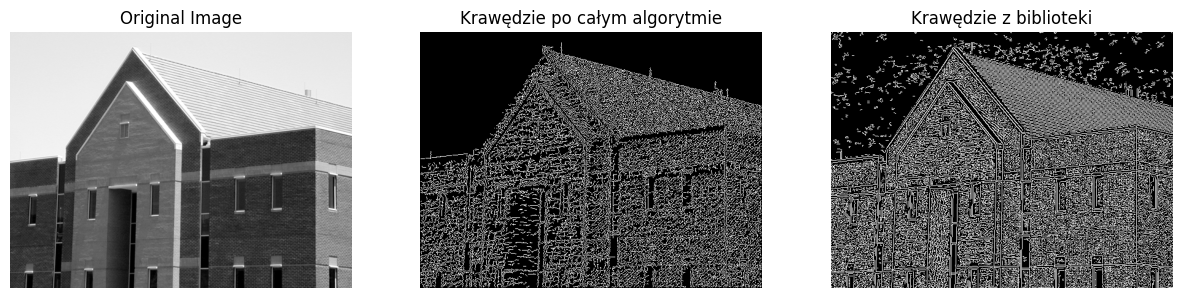

In [10]:
dom = cv2.imread("dom.png", cv2.IMREAD_GRAYSCALE)

g_nh,g_nl = canny(dom, tl=5, th=10)
dom_canny_full = full_canny(dom, g_nh, g_nl)

doc_cv2 = cv2.Canny(dom, 5, 10, None, 3, 1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(dom, cmap="gray")
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(dom_canny_full, cmap="gray")
ax[1].axis('off')
ax[1].set_title('Krawędzie po całym algorytmie')

ax[2].imshow(doc_cv2, cmap="gray")
ax[2].axis('off')
ax[2].set_title('Krawędzie z biblioteki')
